In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import time
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14
from IPython.display import clear_output

import superscreen as sc

In [2]:
length_units = "um"

Lambda = 1e-3

trace_width = 0.5

ro_small = 4.00 + trace_width / 2
ri_small = ro_small - trace_width
ro_large = 10.0 + trace_width / 2
ri_large = ro_large - trace_width

layers = [
    sc.Layer("base", Lambda=Lambda, z0=0),
    sc.Layer("other", Lambda=Lambda, z0=-1),
]

films = [
    sc.Polygon("ring_small", layer="other", points=sc.geometry.circle(ro_small)),
    sc.Polygon("ring_large", layer="base", points=sc.geometry.circle(ro_large)),
]

holes = [
    sc.Polygon("hole_small", layer="other", points=sc.geometry.circle(ri_small)),
    sc.Polygon("hole_large", layer="base", points=sc.geometry.circle(ri_large)),
]

abstract_regions = [
    sc.Polygon(
        "bounding_box",
        layer="base",
        points=sc.geometry.square(2 * ro_large * 1.1),
    )
]

device = sc.Device(
    "device",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

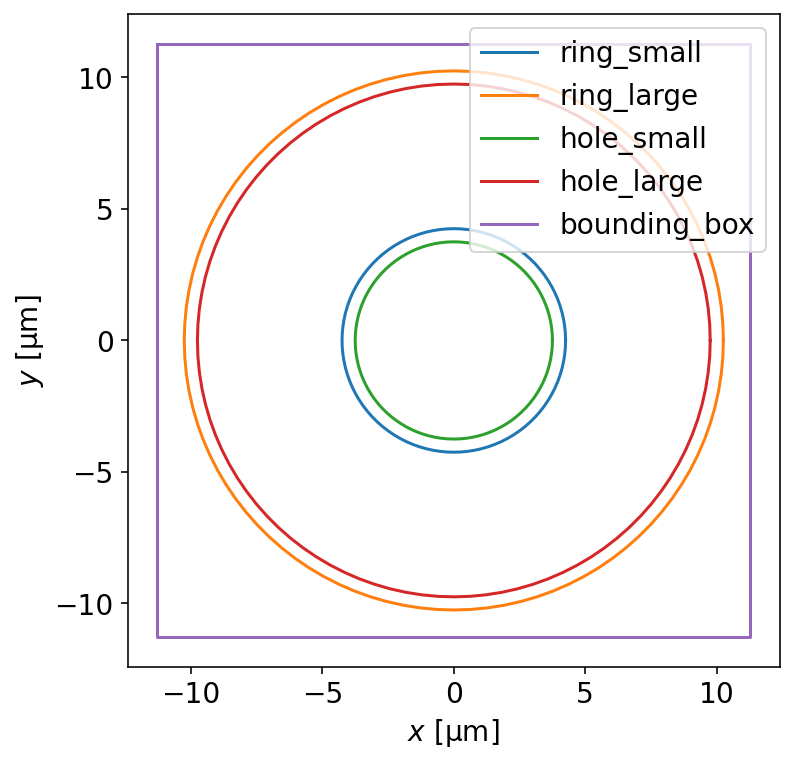

In [3]:
ax = device.plot_polygons(figsize=(6, 6))

In [4]:
device.make_mesh(min_triangles=15000, optimesh_steps=200)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 16082 triangles.
INFO:superscreen.device:Finished generating mesh with 8218 points and 16082 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


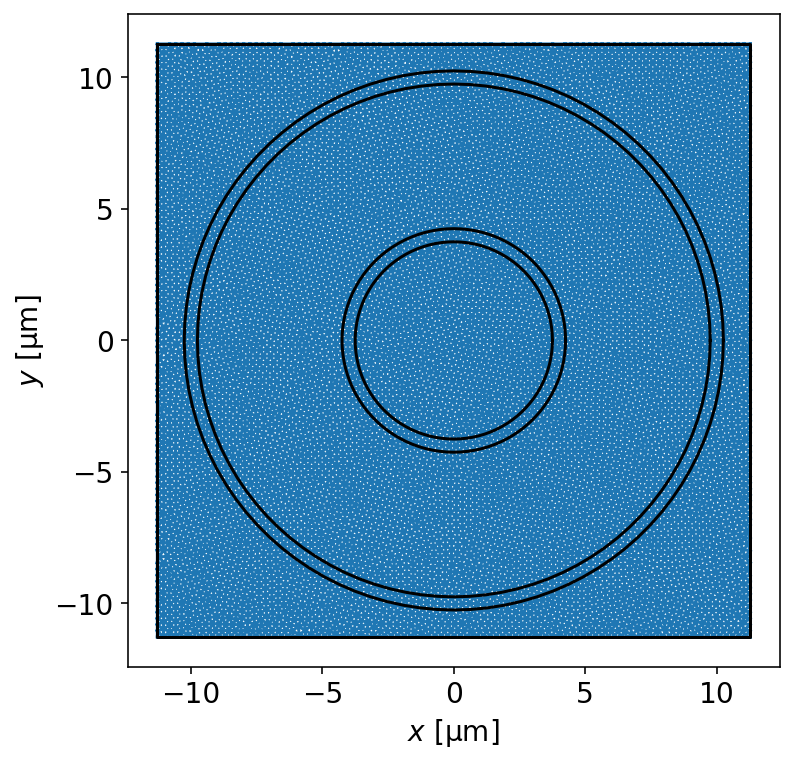

In [5]:
ax = device.plot_mesh(figsize=(6, 6))
ax = device.plot_polygons(ax=ax, color="k", legend=False)

In [6]:
circulating_currents = {"hole_large": "1 mA"}

solutions = sc.solve(
    device=device,
    applied_field=sc.sources.ConstantField(0),
    circulating_currents=circulating_currents,
    iterations=1
)

INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating other response to applied field.
INFO:superscreen.brandt:Calculating screening field at base from other (1/1).
INFO:superscreen.brandt:Calculating screening field at other from base (1/1).
INFO:superscreen.brandt:Calculating base response to applied field and screening field from other layers (1/1).
INFO:superscreen.brandt:Calculating other response to applied field and screening field from other layers (1/1).


In [7]:
M = (solutions[1].polygon_flux()["ring_small"] / device.ureg("1 mA")).to("Phi_0 / A")

In [8]:
print(f"{M:.3e~P}")

1.667×10³ Φ_0/A


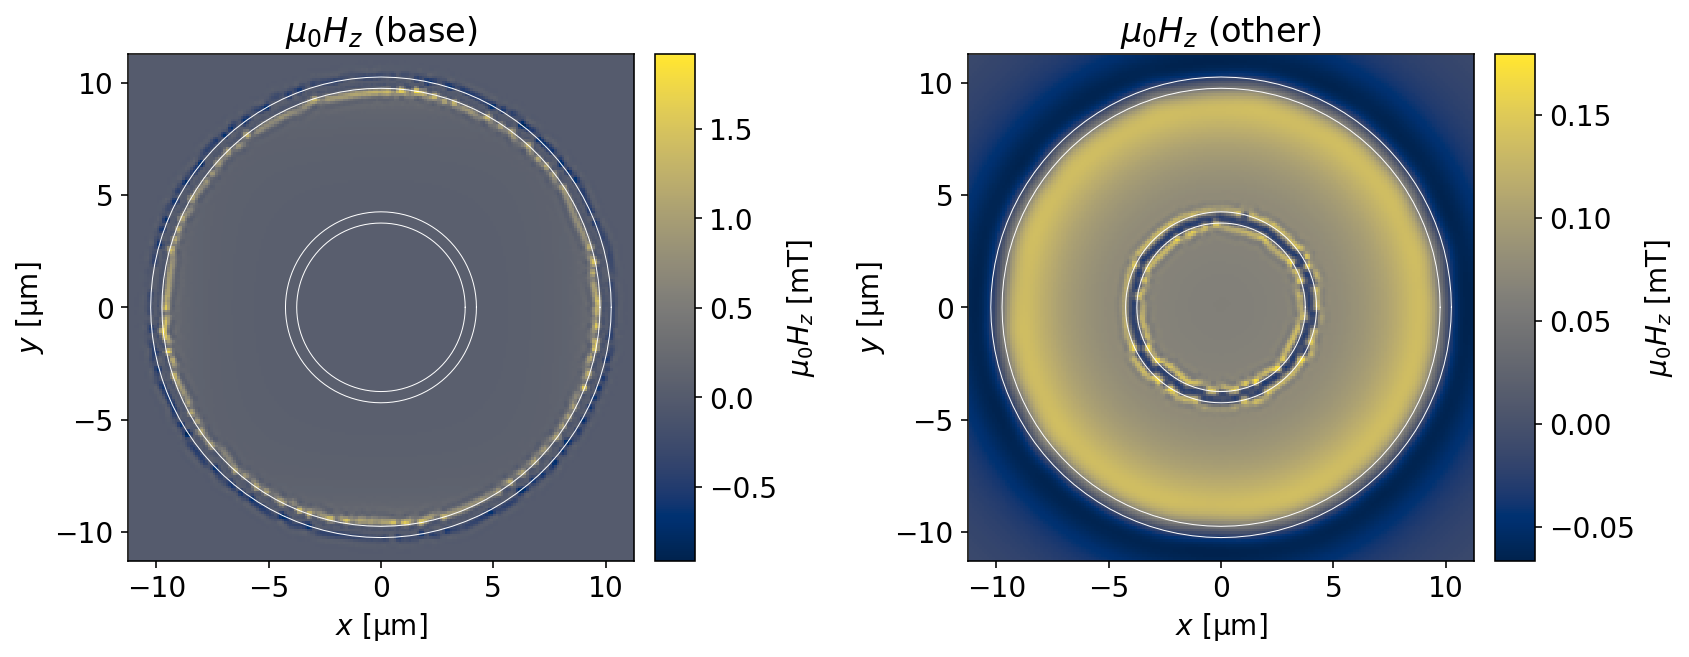

In [9]:
fig, axes = solutions[-1].plot_fields(figsize=(12, 6))
for ax in axes:
    device.plot_polygons(ax=ax, color="w", legend=False, lw=0.5)

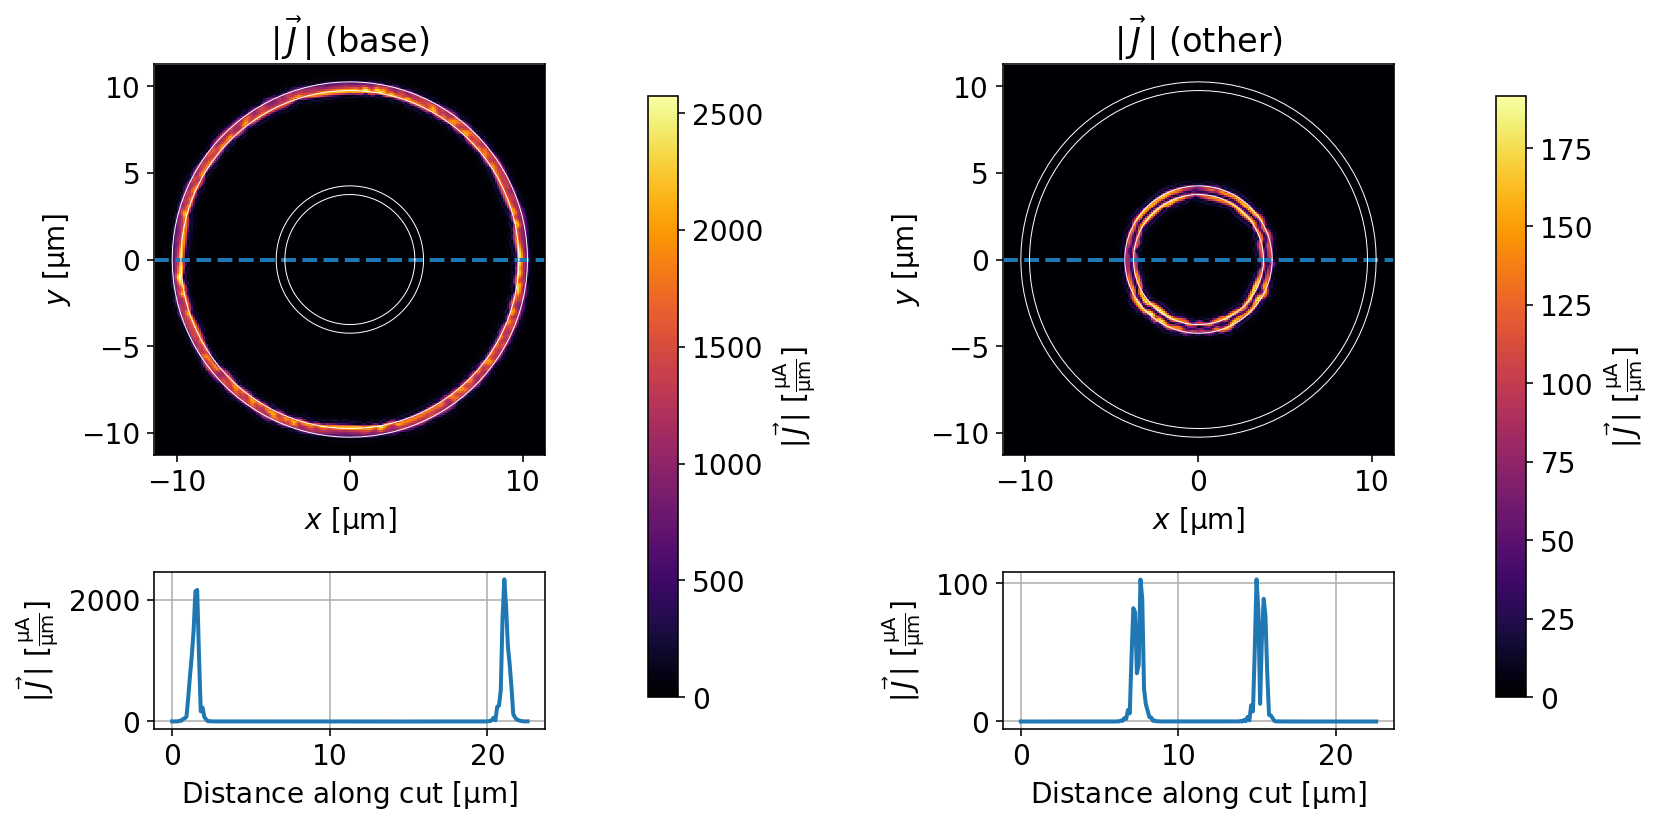

In [10]:
fig, axes = solutions[-1].plot_currents(figsize=(12, 6), streamplot=False, cross_section_ys=[0])
for ax in axes:
    device.plot_polygons(ax=ax, color="w", legend=False, lw=0.5)

In [11]:
from scipy.constants import mu_0
from scipy import special

# r = 4e-6
# R = 10e-6
r = 1e-6 * np.sqrt((ri_small**2 + ro_small**2) / 2)
R = 1e-6 * np.sqrt((ri_large**2 + ro_large**2) / 2)
dz = 1e-6

def M(r, R, dz):
    k = 2 * np.sqrt(r * R) / np.sqrt((r + R)**2 + dz**2)
    m = k**2
    K = special.ellipk(m)
    E = special.ellipe(m)    
    return -mu_0 * np.sqrt(r * R) * ((k - 2 / k) * K + 2 / k * E)

In [12]:
(M(r, R, dz) * device.ureg("H")).to("Phi_0/A").magnitude

1604.2537734614032

In [13]:
dzs = 1e-6 * np.linspace(0, 10, 101)

mutuals = (M(r, R, dzs) * device.ureg("H")).to("Phi_0/A").magnitude

In [14]:
zs = -np.linspace(1, 10, 10)

circulating_currents = {"hole_large": "1 mA"}
I_circ = device.ureg(circulating_currents["hole_large"])

sim_mutuals = []

for z in zs:

    device.layers["other"].z0 = z

    solutions = sc.solve(
        device=device,
        applied_field=sc.sources.ConstantField(0),
        circulating_currents=circulating_currents,
        iterations=1
    )
    
    mutual = (solutions[-1].polygon_flux()["ring_small"] / I_circ).to("Phi_0 / A")
    sim_mutuals.append(mutual.magnitude)

INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating other response to applied field.
INFO:superscreen.brandt:Calculating screening field at base from other (1/1).
INFO:superscreen.brandt:Calculating screening field at other from base (1/1).
INFO:superscreen.brandt:Calculating base response to applied field and screening field from other layers (1/1).
INFO:superscreen.brandt:Calculating other response to applied field and screening field from other layers (1/1).
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating other response to applied field.
INFO:superscreen.brandt:Calculating screening field at base from other (1/1).
INFO:superscreen.brandt:Calculating screening field at other from base (1/1).
INFO:superscreen.brandt:Calculating base response to applied field and screening field from other layers (1/1).
INFO:superscreen.brandt:Calculating other response to applied field and scree

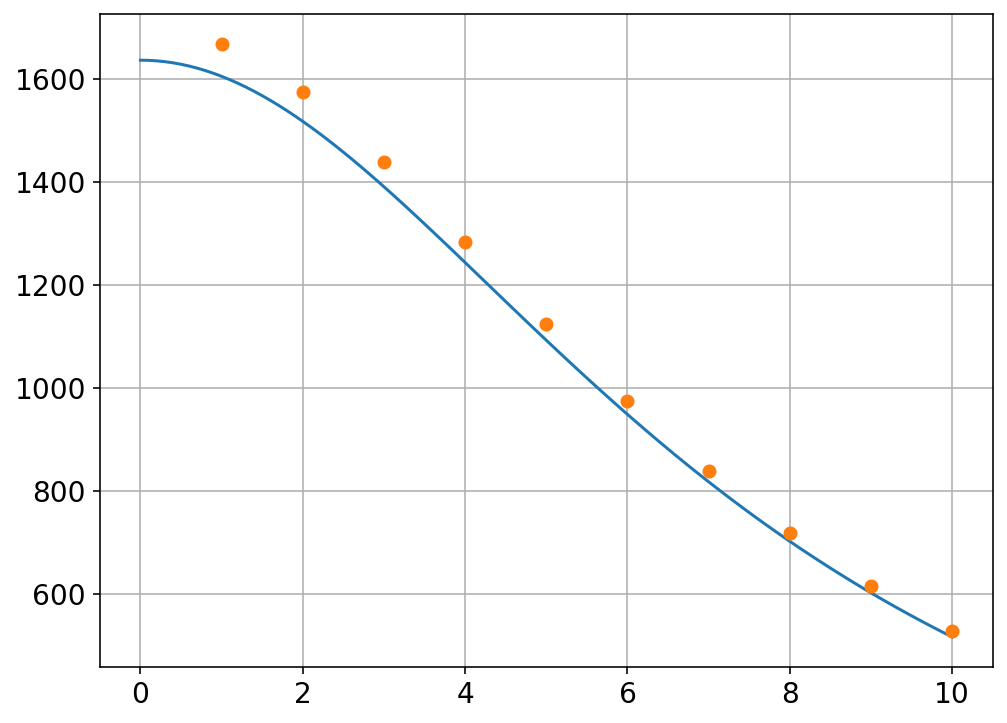

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True)
ax.plot(1e6 * dzs, mutuals, "-")
ax.plot(-zs, sim_mutuals, "o")

In [16]:
mutual = (M(r, R, -zs*1e-6) * device.ureg("H")).to("Phi_0/A").magnitude

In [17]:
100*(np.array(sim_mutuals) - mutual) / mutual

array([3.91811336, 3.71276091, 3.44270694, 3.1576343 , 2.89166277,
       2.66008884, 2.46597519, 2.30644686, 2.17653042, 2.07103036])